In [1]:
# notebook to get numbers for, and plot for diversity trade-off
import pickle
from encode_utils.rerank_data import rerank_dist, rerank_single
from encode_utils.efficient_rerank import get_effrerank_model, run_comstyle
from encode_utils.sco_funct import weightaddprob, default_scofunct
from encode_utils.mt_scores import get_scores_auto
from transformers import AutoTokenizer
import pandas as pd
import numpy as np
import torch
import random
import os
import re
import matplotlib.pyplot as plt
from encode_utils.new_mask_utils import randomsingle, useall
from encode_utils.eval_utils import all_lattice_multi, mean, all_unnoun_multi, get_hyp_sco
device = torch.device('cuda:2' if torch.cuda.is_available() else 'cpu')

2023-01-01 10:13:04.256716: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-01-01 10:13:04.256737: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
# set up information for set
col = {
    "noun_xsum": ["nounsum_reversed/", "nounxsumlargeexplodev2.csv"],
    "noun_fren": ["frtest_reversed/", "nounlargeexplodev1.csv"],
    "mt_fren": ["frtest_reversed/", "frenchlargeexplodev1.csv"],
    "mt_ende": ["detest_reversed/", "germanlargeexplodev1.csv"],
    "mt_enru": ["rutest_reversed/", "russianlargeexplodev1.csv"],
    "mt_fren_b12": ['reversed_mtfren_beam12/', 'mtfrenbeam12v2.csv'],
    "mt_fren_b50": ['reversed_mtfren_beam50/', 'mtfrenbeam50v2.csv'],
    "noun_xsum_b12": ['reversed_xsum_beam12/', 'nounxsumbeam12v2.csv'],
    "noun_xsum_b50": ['reversed_xsum_beam50/', 'nounxsumbeam50v2.csv'],
}
curcol = "noun_xsum"
gsuffix = col[curcol][0]
expl_fname = col[curcol][1]
base = "outputs/graph_pickles/"+gsuffix
goldmetric = "utnoun"
explode_df = pd.read_csv("outputs/score_csvs/"+expl_fname)
#TODO switch back for french-english
if "fren" in curcol:
    SETLEN = len(os.listdir(base))
else:
    SETLEN = int(len(os.listdir(base))/2)

In [3]:
SETLEN = len(os.listdir(base))

In [4]:
# use noun model
if "noun" in expl_fname:
    encodemod = get_effrerank_model("noun")
# use mt model (causal)
else:
    encodemod = get_effrerank_model("comstyle")
xlm_tok = AutoTokenizer.from_pretrained("xlm-roberta-base")

Some weights of the model checkpoint at xlm-roberta-large were not used when initializing XLMRobertaModel: ['lm_head.bias', 'roberta.pooler.dense.weight', 'roberta.pooler.dense.bias', 'lm_head.dense.bias', 'lm_head.decoder.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.weight', 'lm_head.layer_norm.weight']
- This IS expected if you are initializing XLMRobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Encoder model frozen.
Loading weights from /mnt/data1/prasann/latticegen/lattice-generation/COMET/lightning_logs/version_44/checkpoints/epoch=9-step=40000.ckpt.


freeze embeds


In [5]:
args = {
    'setlen':int(SETLEN),
    'tok':xlm_tok, 
    'dev':device,
    'model':encodemod,
    'explode_df':explode_df,
    'base':base,
    'goldmetric':goldmetric,
    'device':device, 
    'efficient':False,
    'noregen':False
}

In [6]:
WEIGHT=50
#DIVWEIGHT = 1
#doadd = True
DIVWEIGHT = 1
doadd = True
    
def tokenprobdiverse (node, used):
    if hasattr(node, "prob"):
        #pcnt+=1
        tcnt = [u.token_idx for u in used].count(node.token_idx)
        return math.log(node.prob) + WEIGHT*node.score - DIVWEIGHT*tcnt
    else:
        #npcnt+=1
        return 1
    
def tokendiverse (node, used, norm):
    if hasattr(node, "score"):
        #pcnt+=1
        tcnt = [u.token_idx for u in used].count(node.token_idx)
        return WEIGHT*node.score - DIVWEIGHT*tcnt
    else:
        #npcnt+=1
        return 1
    
def nodediverse (node, used):
    if hasattr(node, "prob"):
        #pcnt+=1
        if node in used:
            if doadd:
                return math.log(node.prob) + WEIGHT*node.score - DIVWEIGHT
        return math.log(node.prob) + WEIGHT*node.score
    else:
        #npcnt+=1
        return 1
    
def extranodediverse (node, used):
    if hasattr(node, "prob"):
        #pcnt+=1
        if node in used:
            return math.log(node.prob) + WEIGHT*node.score - DIVWEIGHT*used.count(node)
        return math.log(node.prob) + WEIGHT*node.score
    else:
        #npcnt+=1
        return 1

In [7]:
lrefs = list(explode_df['ref'])

In [8]:
NRUNS = 10

# get output for a single index out of available graphs
def test_graph_ind(ind, basedir, scofunct, metric):
    g = pickle.load(open(basedir+str(ind), 'rb'))
    if g['ref'] not in lrefs:
        return None, None, None
    #if g['input'] in old['src']:
    #    return None, None, None
    #try:
    global usedlist
    usedlist = []
    options = []
    # TODO add a verbose option for efficient reranking so that it doesn't blow up nb
    return g['input'], g['ref'], run_comstyle(g, encodemod, scofunct, metric, {'afunc':randomsingle}, False, NRUNS)

# get predictions for a bunch of stuff
def get_all_preds(basedir, scofunct):
    l = len(os.listdir(basedir))
    result = []
    print("will predict total of ", l)
    for i in range(l):
        inp, r, p = test_graph_ind(i, basedir, scofunct)
        result.append({
            'src':inp,
            'hyp':p,
            'ref':r
        })
        print(i)
    result = pd.DataFrame(result)
    return result

In [9]:
# let's use this as our evaluation metric for diversity
def get_unique_ngrams(sentence, tok, n, uns):
    toks = tok(sentence).input_ids
    #print(toks)
    for i in range(len(toks)-n):
        tmp = ""
        for j in range(i, i+n):
            tmp = tmp+"_"+str(toks[j])
        uns.add(tmp)

def cand_unique_ngrams(sentences, tok, n):
    uniques = set()
    for s in sentences:
        get_unique_ngrams(s, tok, n, uniques)
    return uniques

def count_unique_ngrams(sentences, n):
    return len(cand_unique_ngrams(sentences, xlm_tok, n))

In [10]:
def base_unique_ngrams(edf, n):
    uns = edf['ref'].unique()
    ndist = []
    for u in uns:
        segment = edf[edf['ref']==u]
        
        if len(segment)>0:
            ndist.append(count_unique_ngrams(list(segment['hyp']), n))
    return ndist

In [11]:
#ndist = base_unique_ngrams(explode_df, 4)
#print(sum(ndist)/len(ndist))

In [12]:
# plots to show -> 

# Plot 1
# - include random baseline for selecting in terms of quality
# - go from left to right (number of candidates generated, and show score of each)

# Plot 2 
# - show beam search 50 baseline
# - go from left to right, show n-gram diversity metric for each

In [13]:
def get_ind_diverse(ind, metric):
    result = test_graph_ind(ind, base, tokendiverse, metric)
    if result[0] is None:
        return None, None, None
    # get number of unique n-grams added with more generation
    cgrams = []
    for i in range(1, len(result[2])+1):
        cgrams.append(count_unique_ngrams(result[2][:i], 4))

    if "noun" in metric:
        source = "noun"
    else:
        source = result[0]
    # get hypothesis scores
    cscos = []
    # TODO set this up with batching
    for c in result[2]:
        cscos.append(float(torch.sum(get_hyp_sco(c[4:], source, args))))
    return cscos, cgrams, result

def get_diverse_distr(metric, total):
    allcs, allcg = [0]*NRUNS, [0]*NRUNS
    tvals = 0
    for i in range(total):
        cstmp, cgtmp, r = get_ind_diverse(i, metric)
        if cstmp is None:
            #print("skip")
            continue
        for j in range(NRUNS):
            allcs[j] += cstmp[j]
            allcg[j] += cgtmp[j]
        tvals+=1
        print(tvals, " ", i)
    return [c/tvals for c in allcs], [g/tvals for g in allcg]
        

In [14]:
overall = get_diverse_distr("utnoun", SETLEN)

557   1087
558   1091
559   1092
560   1097
561   1098
562   1099
563   1100
564   1102
565   1103
566   1105
567   1108
568   1109
569   1110
570   1112
571   1114
572   1119
573   1120
574   1122
575   1123
576   1124
577   1126
578   1127
579   1130
580   1131
581   1132
582   1135
583   1136
584   1140
585   1143
586   1144
587   1145
588   1146
589   1147
590   1148
591   1150
592   1155
593   1156
594   1157
595   1158
596   1161
597   1162
598   1163
599   1166
600   1167


In [15]:
overall

([1.1223565481603146,
  0.9676461719721555,
  0.9060725154479344,
  0.861249197560052,
  0.8511633169402679,
  0.832240644544363,
  0.8293558774205546,
  0.8174281796316306,
  0.8179277575900779,
  0.8056926445538799],
 [38.94166666666667,
  62.505,
  80.26333333333334,
  94.01333333333334,
  104.20666666666666,
  111.94666666666667,
  117.91,
  123.01166666666667,
  126.5,
  129.79166666666666])

In [16]:
overall = ([1.1223565481603146,
  0.9676461719721555,
  0.9060725154479344,
  0.861249197560052,
  0.8511633169402679,
  0.832240644544363,
  0.8293558774205546,
  0.8174281796316306,
  0.8179277575900779,
  0.8056926445538799],
 [38.94166666666667,
  62.505,
  80.26333333333334,
  94.01333333333334,
  104.20666666666666,
  111.94666666666667,
  117.91,
  123.01166666666667,
  126.5,
  129.79166666666666])


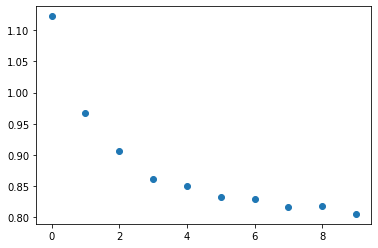

In [17]:
plt.scatter(x=list(range(NRUNS)), y=overall[0])

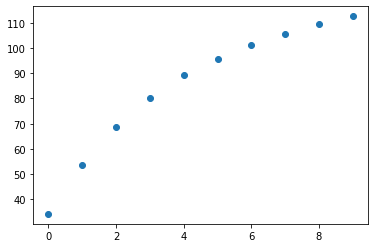

In [54]:
plt.scatter(x=list(range(NRUNS)), y=overall[1])

In [53]:
result = get_ind_diverse(0, "utnoun")

In [ ]:
result

In [16]:
result = test_graph_ind(0, base, tokendiverse, "utnoun")

In [17]:
cgrams = []
for i in range(1, len(result[2])+1):
    cgrams.append(count_unique_ngrams(result[2][:i], 4))

In [18]:
cgrams

[46, 68, 89, 106, 106, 125, 132, 137, 137, 137]

In [20]:
result[2]

["<s> A senior army officer in the Democratic Republic of Congo has been accused by at least five women of ordering a mass rape of more than 50 women in the capital, Kinshasa, on New Year's Day.",
 "<s> A senior army officer in the Democratic Republic of Congo has been charged with rape, according to three women who have been treated in a hospital in the capital, Kinshasa, on New Year's Eve.",
 '<s> A senior army officer in the Democratic Republic of Congo is being investigated for alleged involvement in the rape of more than 50 women and girls in a single day.',
 '<s> A senior army officer in the Democratic Republic of Congo has been arrested on suspicion of raping dozens of women and girls in a single attack.',
 "<s> A senior army officer in the Democratic Republic of Congo has been charged with rape, according to three women who have been treated in a hospital in the capital, Kinshasa, on New Year's Day.",
 '<s> A senior army officer in the Democratic Republic of Congo has been accu

In [ ]:
# for 100 examples, generate diverse options (up to 20), score each of them
SET = 100
i = 0
while SET>0:
    

In [13]:
import pickle

In [18]:
with open("outputs/graph_pickles/exploded_mtfren_beam12/0", "rb") as file:
    res = pickle.load(file)

In [19]:
res[1]

['A slow new year for the world economy',
 'A new slow year for the world economy',
 'A slow new year for the global economy',
 'A new slow year for the global economy',
 'A Slow New Year for the World Economy',
 'A New Slow Year for the World Economy',
 'A Slow New Year for the Global Economy',
 'A New Slow Year for the Global Economy',
 'A slow new year for the world economy.',
 'A slow new year for the global economy.',
 'A new slow year for the world economy.',
 'A new slow year for the global economy.']

In [4]:
res = get_ind_diverse(0, "utnoun")

NameError: name 'test_graph_ind' is not defined

In [11]:
cands = [r[4:] for r in res[2][2]]
scos = res[0]

In [44]:
a = torch.ones(1, 2, 3)

RuntimeError: expand(torch.FloatTensor{[1, 2, 3]}, size=[3]): the number of sizes provided (1) must be greater or equal to the number of dimensions in the tensor (3)

In [11]:
# TODO put elsewhere - make batched version of get_hyp_sco (TODO also do dataloader setup or smth)
def causalmask (a, dev):
    masksdef = torch.zeros((a.shape[0], a.shape[1],a.shape[1]), device=dev)
    for i in range(len(a)):
        lim = int(torch.sum(a[i]))
        masksdef[i, :lim, :lim] = torch.tril(torch.ones((lim, lim)))
    return masksdef

def batch_hyp_sco(srcs, hyps, metric):
    tok = args['tok']
    dev = args['device']
    model = args['model']
    
    out_toks = tok(hyps, return_tensors='pt', padding=True, truncation=True).to(dev)
    out_tokens = out_toks.input_ids
    hypmask = causalmask(out_toks.attention_mask, device)
    
    positionids = None
    toked_inp = tok(srcs, padding=True, truncation=True, return_tensors="pt").to(dev)
    
    predout = model(toked_inp.input_ids, toked_inp.attention_mask, out_tokens, positionids, \
        hypmask)
    
    return torch.sum(predout['score'], 1)#, toked_inp, out_tokens, positionids, hypmask
    
# get token level scores from model, given hypothesis and input source
def get_hyp_sco(inphyp, inpsrc, args):
    tok = args['tok']
    dev = args['device']
    model = args['model']

    # calculate inputs
    tokens = tok(inphyp, return_tensors='pt', truncation=True).to(dev)
    tokens = tokens.input_ids
    positionids = None
    toked_inp = tok([inpsrc], return_tensors="pt").to(dev)
    # get causal mask
    tmpmask = torch.tril(torch.ones(len(tokens[0]), len(tokens[0]))).unsqueeze(0).to(dev)
    # run through model
    predout = model(toked_inp.input_ids, toked_inp.attention_mask, tokens, positionids, \
        tmpmask)
    return torch.sum(predout['score'])#, toked_inp, tokens, positionids, tmpmask

In [51]:
a = torch.ones(2, 3, 1)
b = torch.ones(2)/3

In [64]:
a/b.unsqueeze(-1).unsqueeze(-1)

torch.Size([2, 3, 1])

In [14]:
btest = batch_hyp_sco(["noun"]*10, cands, args)
htest = get_hyp_sco(cands[3], "noun", args)

In [14]:
import time

In [15]:
tmp = explode_df.loc[:32]

In [43]:
s = time.time()
batch_hyp_sco(["noun"]*len(tmp), list(tmp['hyp']), args)
tot = time.time()-s
print(tot)

0.05416083335876465


In [16]:
tind = tmp.loc[0]
tind

Unnamed: 0                                                     0
src            Comme pour tout compromis, les parties prenant...
ref            As with any compromise, the contending parties...
hyp            As with any compromise, stakeholders would hav...
dcqeold                                                  0.67299
comet                                                   0.776076
cqe                                                     0.526303
posthoc                                                  0.39046
dupcqeprev1                                              0.64051
dupcqe                                                  0.640568
Name: 0, dtype: object

In [17]:
tind['src']

'Comme pour tout compromis, les parties prenantes auraient à la fois à perdre et à gagner dans cet arrangement. '

In [18]:
get_hyp_sco(tind['hyp'], tind['src'], args)

tensor(0.6200, device='cuda:2', grad_fn=<SumBackward0>)

In [19]:
batch_hyp_sco(list(tmp['src']), list(tmp['hyp']), args)

tensor([[0.6200],
        [0.6123],
        [0.5721],
        [0.6260],
        [0.6966],
        [0.6428],
        [0.5876],
        [0.7055],
        [0.6402],
        [0.6341],
        [0.5645],
        [0.7112],
        [0.6950],
        [0.6687],
        [0.6928],
        [0.6689],
        [0.6937],
        [0.6920],
        [0.6818],
        [0.6978],
        [0.6919],
        [0.6104],
        [0.6473],
        [0.6588],
        [0.8014],
        [0.7982],
        [0.7970],
        [0.7946],
        [0.7982],
        [0.7975],
        [0.7970],
        [0.8056],
        [0.8075]], device='cuda:2', grad_fn=<SumBackward1>)

In [15]:
btest

tensor([[1.3034],
        [1.1236],
        [1.2539],
        [1.3034],
        [0.9848],
        [0.9704],
        [0.8752],
        [1.2966],
        [0.8793],
        [1.3001]], device='cuda:2', grad_fn=<SumBackward1>)

In [18]:
htest

tensor(1.3034, device='cuda:2', grad_fn=<SumBackward0>)

In [44]:
inpstmp = btest[1].input_ids

In [47]:
inpstmp/(torch.max(inpstmp, 1).values)

RuntimeError: The size of tensor a (4) must match the size of tensor b (10) at non-singleton dimension 1

In [48]:
inpstmp

tensor([[  0, 110, 309,   2],
        [  0, 110, 309,   2],
        [  0, 110, 309,   2],
        [  0, 110, 309,   2],
        [  0, 110, 309,   2],
        [  0, 110, 309,   2],
        [  0, 110, 309,   2],
        [  0, 110, 309,   2],
        [  0, 110, 309,   2],
        [  0, 110, 309,   2]], device='cuda:2')

In [32]:
btest

tensor([[1.2586, 1.3145, 1.6432, 1.7925, 1.4084, 1.3145, 1.8486, 1.6901, 1.3145,
         1.8486],
        [1.2415, 1.2966, 1.6208, 1.7681, 1.3893, 1.2966, 1.8234, 1.6671, 1.2966,
         1.8234],
        [0.7550, 0.7885, 0.9856, 1.0752, 0.8448, 0.7885, 1.1088, 1.0138, 0.7885,
         1.1088],
        [0.6813, 0.7116, 0.8895, 0.9704, 0.7624, 0.7116, 1.0007, 0.9149, 0.7116,
         1.0007],
        [1.1618, 1.2134, 1.5167, 1.6546, 1.3001, 1.2134, 1.7063, 1.5601, 1.2134,
         1.7063],
        [1.2415, 1.2966, 1.6208, 1.7681, 1.3893, 1.2966, 1.8234, 1.6671, 1.2966,
         1.8234],
        [0.5986, 0.6253, 0.7816, 0.8526, 0.6699, 0.6253, 0.8793, 0.8039, 0.6253,
         0.8793],
        [0.6517, 0.6807, 0.8509, 0.9282, 0.7293, 0.6807, 0.9572, 0.8752, 0.6807,
         0.9572],
        [1.2479, 1.3034, 1.6292, 1.7773, 1.3965, 1.3034, 1.8329, 1.6758, 1.3034,
         1.8329],
        [0.5926, 0.6189, 0.7737, 0.8440, 0.6632, 0.6189, 0.8704, 0.7958, 0.6189,
         0.8704]], device='c

In [150]:
htest[4][0]

tensor([[1., 0., 0.,  ..., 0., 0., 0.],
        [1., 1., 0.,  ..., 0., 0., 0.],
        [1., 1., 1.,  ..., 0., 0., 0.],
        ...,
        [1., 1., 1.,  ..., 1., 0., 0.],
        [1., 1., 1.,  ..., 1., 1., 0.],
        [1., 1., 1.,  ..., 1., 1., 1.]], device='cuda:2')